# Time-Series Forecast - Amazon Halloween Sales

# Time-Series Forecast - Amazon Halloween Sales

In this notebook, I'm going to examine a few models for time series forecasting, in order to predict the demand for our Halloween products on Amazon.

Models: SARIMAX, GAM, Prophet, Linear Regression, Lasso, Ridge, ElasticNet, KNN, SVR, Decision Tree, Random Forest and XGBoost.

###Selling, Storing and Shipping via Amazon:

In the Amazon E-commerce business there are 2 options to store and deliver the products to the customers:
1. Upload the product on Amazon for sale but store it in your warehouse and take care of the shipping by yourself.
2. Send an inventory to Amazon, and Amazon takes care of the storage and the delivery directly to the customers.

In the second choice, Amazon takes an extra fee for that service but also gives a priority for these products and shows these lists in a better place on the page.

Sending stock to Amazon can provide a great potential of selling more merchandise and increase seller profits, but with that opportunity come risk. Sometimes the product is seasonal and if you don't succeed in selling it on time you are stuck with overstock which no one will buy until next year and you actually need to get rid of the stock and therefore lose money.

###The Task:

The task is to send stock to Amazon, stock of products for Halloween, and it needs to be sent 2 months before the event ends (31/10). 
Therefore we need to predict the total sales 2 months ahead.
Even though the data contains observations from 2021, the forecast period we trying to predict is the Halloween accrue at 2020 (31/10/2020) which will be the test set. 


###The Data:

The data I have got is a daily sales (quantity) for products tagged as Halloween products. These univariate time series contain quantities and dates (as index) from 2015 until 2021. I won't share because of confidential issues.

In addition, there is a table of holidays and their dates of each year (in this case we are using Halloween only).

###Table of Contents:

- Packages
- Helper Functions
- Quick EDA
- Holt-Winters Exponential Smoothing
- SARIMAX Model
- GAM - General Additive Model
- Facebook Prophet Model
- Classic ML Models
- Evaluation and Comparison

# Packages

### Required to install, doesn't come build-in in Google Colab.

In [ ]:
pip install optuna

In [ ]:
pip install pygam

In [ ]:
pip install fbprophet

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy
import sys


# Visualisation packages
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.ticker as ticker
import seaborn as sns


# Bayesian optimization search for hyperparameter tuning
import optuna

# For the 1st model - Holt-Winters
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# For the 2st model - SARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For the 3nd model - GAM
from pygam import LinearGAM

# For the 4rd model - Prophet
from fbprophet import Prophet
from fbprophet.make_holidays import make_holidays_df
from fbprophet.diagnostics import cross_validation,performance_metrics

# ML algorithms for the ensemble part
from sklearn.model_selection import cross_val_score,TimeSeriesSplit
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import MinMaxScaler 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Ignore warnings and output
import warnings
warnings.simplefilter(action='ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Helper Functions

Function for importing the data sets.
The function converts the date variable into a date data type, \
filling days without sales with 0, keeping the relevant dates, and aggregating the sales by time period (days or months),\
 doing so by summing up the sales from all the products for the specific period. 

In [3]:
def import_data(freq = 'M',last_date = '2021-11-01'):
  # Holidy Data
  holidays_data = pd.read_csv(r'/content/drive/My Drive/Halloween/holidays.csv',parse_dates =['ds'])
  
  # Sales Data
  data = pd.read_csv(r'/content/drive/My Drive/Halloween/Halloween Data.csv',parse_dates =['purchase_date'])
  data['purchase_date'] = data['purchase_date'].dt.date
  data = data.sort_values(by='purchase_date')
  df = data.groupby(by=['purchase_date']).agg(y=('quantity','sum'))
  df = df.reindex(pd.date_range(start=df.index.min(),end=df.index.max(),freq='1D')) 
  df.fillna(0,inplace=True)

  df['ds'] = df.index
  df['ds'] = pd.to_datetime(df['ds'])
  grouper = pd.Grouper(key='ds', freq=freq)
  df = df.groupby(grouper)['y'].sum().reset_index()
  df = df.set_index('ds')

  df = df[df.index <= last_date]
  return df,holidays_data 

Function for split the data into training and test sets in specific date we want.

In [4]:
def split(df,test_date = '2021-09-01'):
  train = df[df.index < test_date].copy()
  test = df[df.index >= test_date].copy() 
  return train, test

Function for making graph using Plotly.
The function is built to make a comparison between the actual data and the forecast the model made. \
There are also options to plot training data and the model predictions for In-sampled data in the same graph with the forecast Out-Sampled data.

In [5]:
# For Colab
def make_graph(test_pred, test, dates, train_pred=None, train=None, with_train=False, with_boundries = False, lower_series=None, upper_series=None):

  fig = go.Figure()
  if with_train:
    fig.add_trace(go.Scatter(x=train.index, y=train['y'], name='Actual - Train',line=dict(color='royalblue', width=3)))
    fig.add_trace(go.Scatter(x=train_pred.index, y=train_pred, name='Predicted - Train',line=dict(color='firebrick', width=3)))

  fig.add_trace(go.Scatter(x=dates, y=test, name='Actual - Test',line=dict(color='royalblue', width=3)))
  fig.add_trace(go.Scatter(x=dates, y=test_pred, name='Forecast - Test',line=dict(color='firebrick', width=3)))
  fig.update_layout(title='Quantity - Prediction Vs. Actual', title_font_size=30, xaxis_title='Date', yaxis_title='Quantity')

  if with_boundries:
    fig.add_trace(go.Scatter(name='Lower Bound', x=lower_series.index, y=lower_series, marker=dict(color="#444"),
                             line=dict(width=0), mode='lines', fillcolor='rgba(68, 68, 68, 0.1)', fill='tonexty', showlegend=False))

    fig.add_trace(go.Scatter(name='Upper Bound', x=upper_series.index, y=upper_series, marker=dict(color="#444"), line=dict(width=0),
                              mode='lines', fillcolor='rgba(68, 68, 68, 0.1)', fill='tonexty', showlegend=False))

  fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
  fig.show()

In [6]:
# For Github 

def make_graph2(test_pred, test, test_dates, train_pred=None, train=None, train_dates=None, with_train=False):

  fig, ax1 = plt.subplots(figsize=(14,6))
  ax1.set_title("Quantity - Prediction Vs. Actual", fontsize=22,fontweight='bold')
  plt.xticks(fontsize=10,rotation=75,fontweight='bold',ha='center')
  ax1.set_ylabel('Quantity', fontsize=16,fontweight='bold')
  plt.yticks(fontsize=10, fontweight='bold')
  plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
  
  marker = ''
  
  if with_train:
    ax1 = plt.plot(train_dates, train, linewidth=2.5, alpha=0.9, color='darkblue', label='Actual - Train')
    ax1 = plt.plot(train_dates, train_pred, linewidth=3, alpha=0.9, color='darkred', label='Forecast - Train')
    marker = 'o'  
  ax1 = plt.plot(test_dates, test, linewidth=2.5, alpha=0.9, color='darkblue',marker=marker, label='Actual - Test')
  ax1 = plt.plot(test_dates, test_pred, linewidth=3, alpha=0.9, color='darkred',marker=marker, label='Forecast - Test')
  plt.legend()
  plt.box(False)
  plt.show()

Shows the forecast metrics performance:
- Error for all periods - absolute and percentage.
- Mean absolute error (MAE).
- Root mean squared error (RMSE).
- Mean absolute percentage error (MAPE).

In [7]:
def evaluation(pred, test,is_print=False):
  total_pred = round(sum(pred))
  total_test = sum(test)
  period_error = round(sum(pred) - sum(test))
  period_error_perc = round((sum(pred) - sum(test)) / sum(test), 3)*100
  mae = round(np.mean(np.abs(pred - test)), 3)
  rmse = round(((np.mean((pred - test)**2))**0.5), 4)
  mape = round(np.mean(np.abs((test - pred) / test)) * 100, 4)
  
  if is_print:
    print("Total Predicted Quantity:" , str(total_pred),'\n')
    print("Total Actual Quantity:" , str(total_test),'\n')
    print("Total Period Error:", str(period_error),'\n')
    print("Total Period % Error:", str(period_error_perc),"%",'\n')
    print("MAE:", str(mae),'\n')
    print("RMSE:", str(rmse),'\n')
    print("MAPE:", str(mape),"%")
  
  return [total_pred,total_test,period_error,period_error_perc,mae,rmse,mape]

One-Hot encoding function - convert multi-categorical feature into dummy variable (0 or 1).

In [8]:
def create_dummies(df, column_name):
    """
    Create dummy variable from categorical variable.
    """
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, dummies], axis=1)
    df.drop(columns = [column_name], inplace = True)
    return df

Convert the monthly predictions into daily predictions by last year's distribution.

In [9]:
def months_to_days(pred,start_date='2020-09-01',end_date='2020-11-01'):
  df,holidays_data = import_data('D')
  daily_data_test = df.loc[(df.index >= start_date) & (df.index <= end_date),'y'].values
  daily_data_test = daily_data_test/daily_data_test.sum()
  pred = daily_data_test*pred.sum()
  return pred

# Quick EDA

In [10]:
df,holidays_data = import_data(freq = 'D',last_date = '2021-11-01')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2497 entries, 2015-01-01 to 2021-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       2497 non-null   float64
dtypes: float64(1)
memory usage: 39.0 KB


In [12]:
df.describe()

,y
count,2497.000000
mean,146.440529
std,306.024468
min,0.000000
25%,27.000000
50%,51.000000
75%,88.000000
max,2438.000000


In [13]:
df.isnull().sum()

y    0
dtype: int64

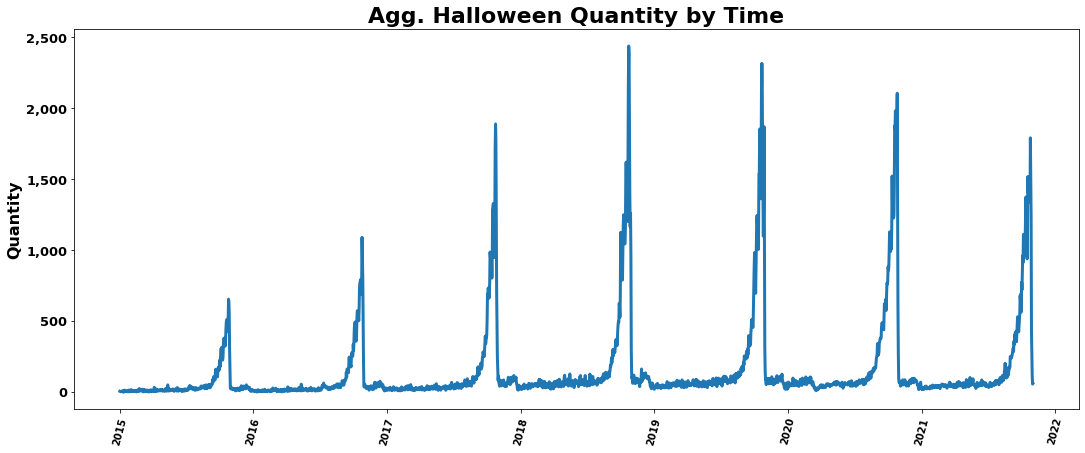

In [14]:

fig, ax1 = plt.subplots(figsize=(18,7))
ax1.set_title("Agg. Halloween Quantity by Time", fontsize=22,fontweight='bold')
plt.xticks(fontsize=10,rotation=75,fontweight='bold',ha='center')
ax1.set_ylabel('Quantity', fontsize=16,fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

ax1 = plt.plot(df.index, df.y, linewidth=3)
    
plt.show()

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['y'],line=dict(color='royalblue', width=3)))
fig.update_layout(title='Agg. Halloween Quantity by Time', title_font_size=30, xaxis_title='Date', yaxis_title='Quantity')
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.show()

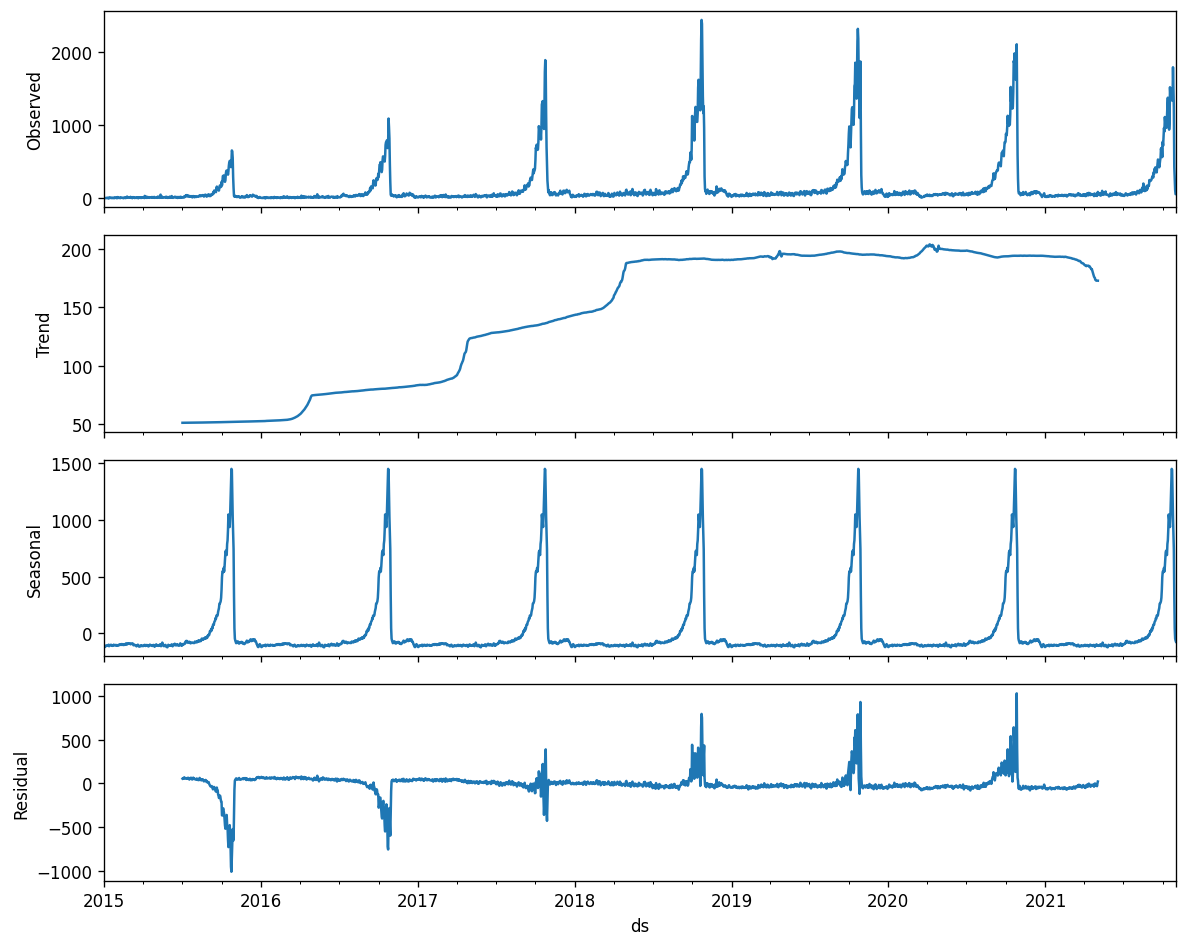

In [16]:
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':120})
result = seasonal_decompose(df['y'], model='additive',freq=365)
result.plot()
plt.show()

#Holt Winter's Exponential Smoothing

The Holt-Winters method is a very common time series forecasting procedure capable of including both trend and seasonality. The Holt-Winters method itself is a combination of 3 methods built one on top each other:

####**Exponential Smoothing:** 
The Exponential Smoothing (ES) technique forecasts the next value using a weighted average of all previous values where the weights decay exponentially from the most recent to the oldest historical value. The ES technique has two big shortcomings: It cannot be used when your data exhibits a trend or seasonal variations.

####**Holt Exponential Smoothing:** 
The Holt ES technique fixes one of the two shortcomings of the simple ES technique. Holt ES can be used to forecast time series data that has a trend. But Holt ES fails in the presence of seasonal variations in the time series.

####**Holt-Winters Exponential Smoothing:** 
The Holt-Winters ES modifies the Holt ES technique so that it can be used in the presence of both trend and seasonality.

For more detail read these articles/blog posts [1](https://medium.com/analytics-vidhya/a-thorough-introduction-to-holt-winters-forecasting-c21810b8c0e6), [2](https://timeseriesreasoning.com/contents/holt-winters-exponential-smoothing/), [3](https://otexts.com/fpp2/holt-winters.html)

\\

####**Additive Method Example:**

$ Forecast: \hat{Y}_{t+h|t} = L_{t} + hT_{t} + S_{t+h-m}\\
Level: L_{t} = \alpha(Y_{t} - S_{t-m}) + (1 - \alpha)(L_{t-1} + T_{t-1})\\
Trend: T_{t} = \beta(L_{t} - L_{t-1}) + (1 - \beta)T_{t-1}\\
Seasonal: S_{t} = \gamma (y_{t}-L_{t-1}-T_{t-1}) + (1-\gamma)S_{t-m}$

\\
**$h$** - Horizone - time steps out into the future. \\
**$m$** - Time period/yr, 12 for months.

**Note:** For the Level, Trend and Seasonal components estimation of initial conditions are required.


In [17]:
df,holidays_data = import_data('M')

train,test = split(df)
train2, val = split(train, test_date='2020-08-31')

In [18]:
def objective(trial):
  trend = trial.suggest_categorical('trend',['add', 'mul', None])
  seasonal = trial.suggest_categorical('seasonal',['add', 'mul', None])
    
  model = ExponentialSmoothing(train2.y, trend=trend, seasonal=seasonal,seasonal_periods=12)


  alpha = trial.suggest_float('alpha',0, 1)
  beta = trial.suggest_float('beta',0, 1)
  gamma = trial.suggest_float('gamma',0, 1)
  use_boxcox = trial.suggest_categorical('use_boxcox',[True, False, 'log'])
  remove_bias = trial.suggest_categorical('remove_bias',[True, False])

  fitted = model.fit(smoothing_level=alpha,
                       smoothing_slope=beta,
                       smoothing_seasonal=gamma,
                       use_boxcox=use_boxcox,
                       remove_bias=remove_bias)
                       
    
  pred = fitted.forecast(2)
  mse = np.mean((val.y - pred)**2)
  return mse

study = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=1234))
study.optimize(objective, n_trials=1000)
best_params = study.best_params

print(best_params)

{'trend': None, 'seasonal': 'add', 'alpha': 0.1019721593441583, 'beta': 0.28652883621504066, 'gamma': 7.827850189435508e-05, 'use_boxcox': True, 'remove_bias': True}


In [19]:
holt = ExponentialSmoothing(train.y, trend=best_params['trend'], seasonal=best_params['seasonal'],seasonal_periods=12)
fitted = holt.fit(smoothing_level=best_params['alpha'], smoothing_slope=best_params['beta'], smoothing_seasonal=best_params['gamma'],
                   use_boxcox=best_params['use_boxcox'], remove_bias=best_params['remove_bias'])

holt_train_pred = fitted.fittedvalues
holt_test_pred  = fitted.forecast(2)

In [20]:
make_graph(holt_test_pred.values, test.y, test.index, holt_train_pred, train, with_train=True)

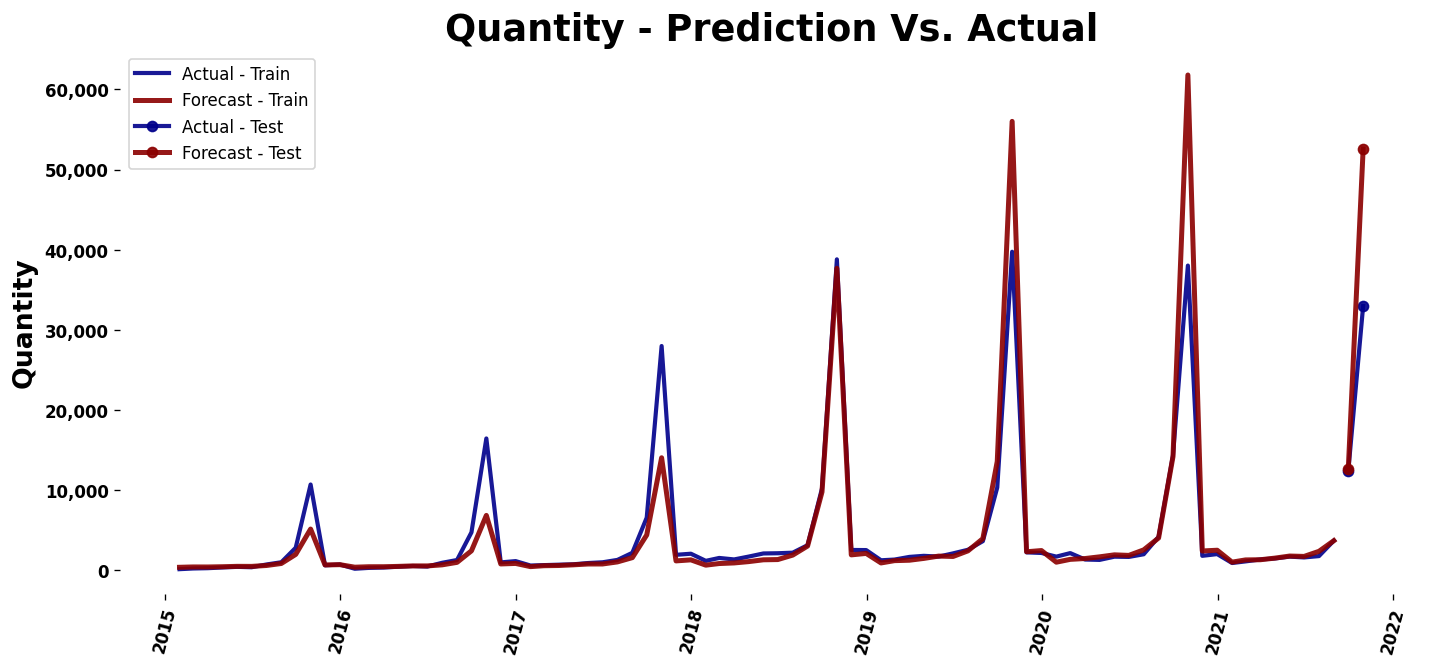

In [21]:
make_graph2(holt_test_pred.values, test.y, test.index, holt_train_pred.values, train.y, train.index, with_train=True)

In [22]:
temp = evaluation(holt_train_pred.values,train.y.values, is_print=True)

Total Predicted Quantity: 320225 

Total Actual Quantity: 320225.0 

Total Period Error: 0 

Total Period % Error: 0.0 % 

MAE: 1230.119 

RMSE: 3838.3799 

MAPE: 25.2431 %


The predictions are in months intervals, in order to convert the into days interval, we will use the months_to_days function and assume that the distribution in 2021 will be the same as in 2020.

In [23]:
df,holidays_data = import_data(freq='D')
train,test = split(df)
holt_test_pred = months_to_days(holt_test_pred.values)

In [24]:
make_graph(holt_test_pred, test.y, test.index)

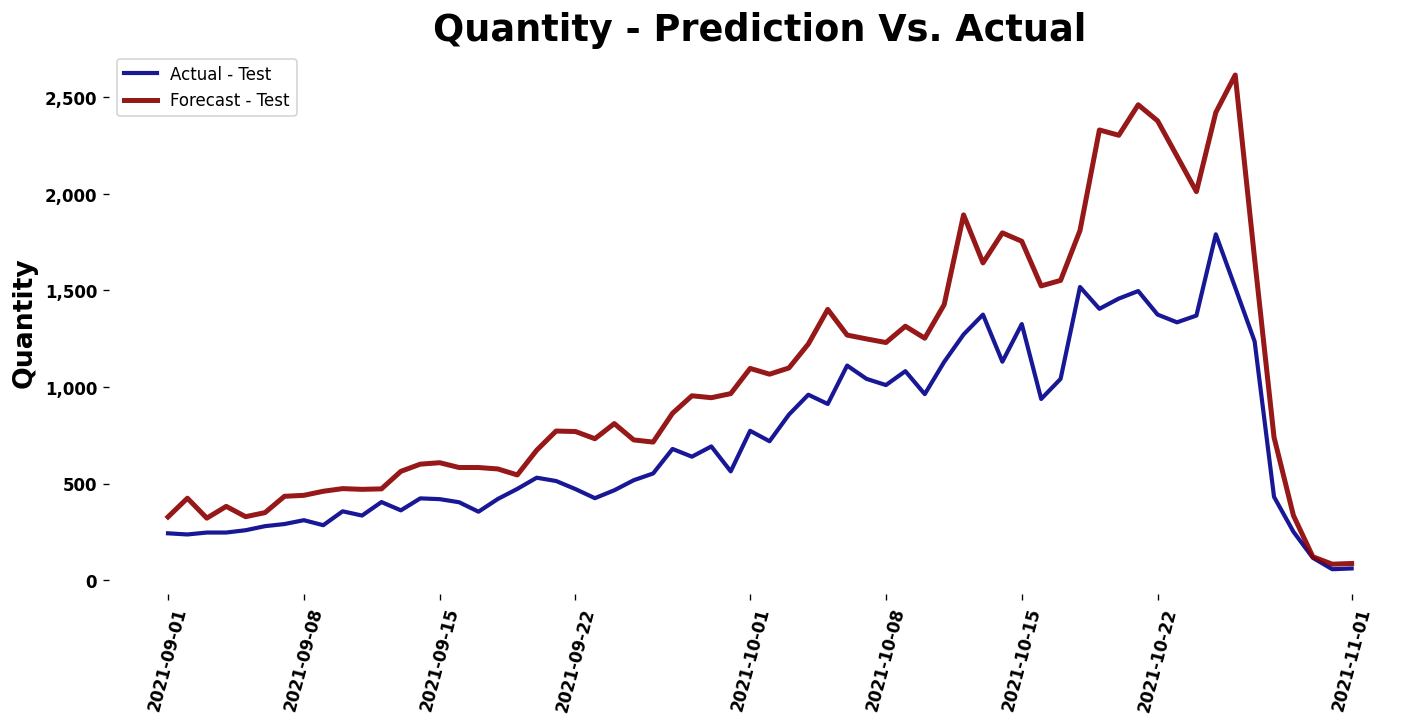

In [25]:
make_graph2(holt_test_pred, test.y, test.index)

In [26]:
temp = evaluation(holt_test_pred,test.y.values, is_print=True)

Total Predicted Quantity: 65209 

Total Actual Quantity: 45437.0 

Total Period Error: 19772 

Total Period % Error: 43.5 % 

MAE: 318.899 

RMSE: 411.424 

MAPE: 43.2343 %


# SARIMAX Model

**SARIMA** is an acronym that stands for Seasonal AutoRegressive Integrated Moving Average. \
**SARIMA** is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

**S – seasonality**. \
**AR - Autoregression:** A model that uses the dependent relationship between observation and some number of lagged observations.

$Y_t = \beta_0 + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \beta_3 Y_{t-3} + \beta_p Y_{t-p} + \epsilon_t $


**I - Integrated:** The use of differencing of raw observations (e.g. subtracting an observation from observation at the previous time step) to make the time series stationary.

$Y_t' = Y_t - Y_{t-1}$          - 1st order difference

$Y_t'' = Y'_t - Y'_{t-1}$          - 2nd order difference

**MA - Moving Average:** A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

$Y_t = \alpha_0 + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + \phi_3 \epsilon_{t-3} + \phi_p \epsilon_{t-q} + \epsilon_t $

There are three trend elements that require configuration.
They belong to the ARIMA part, specifically:

- `p`: Trend autoregression order.
- `d`: Trend difference order.
- `q`: Trend moving average order.


In addition, there are four seasonal elements that are not part of ARIMA that must be configured; they are:

- `P`: Seasonal autoregressive order.
- `D`: Seasonal difference order.
- `Q`: Seasonal moving average order.
- `m`: The number of time steps for a single seasonal period.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

In [27]:
df,holidays_data = import_data('M')

train,test = split(df)
train2, val = split(train, test_date='2020-08-31')

First, I am going to check if the series is stationary using the Augmented Dickey-Fuller test, choosing a P-value threshold of 5%. \
The null hypothesis is the data is **not** stationary. 

In [28]:
result = adfuller(train2.y.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.732760
p-value: 0.838081


P-value is higher than the threshold. Therefore, we can't reject the null hypothesis, so the series is not stationary and differencing is necessary.

In [29]:
result = adfuller(train2.y.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.725730
p-value: 0.000075


A quick look at ACF and PACF plots for the original series, first and second-order differencing.

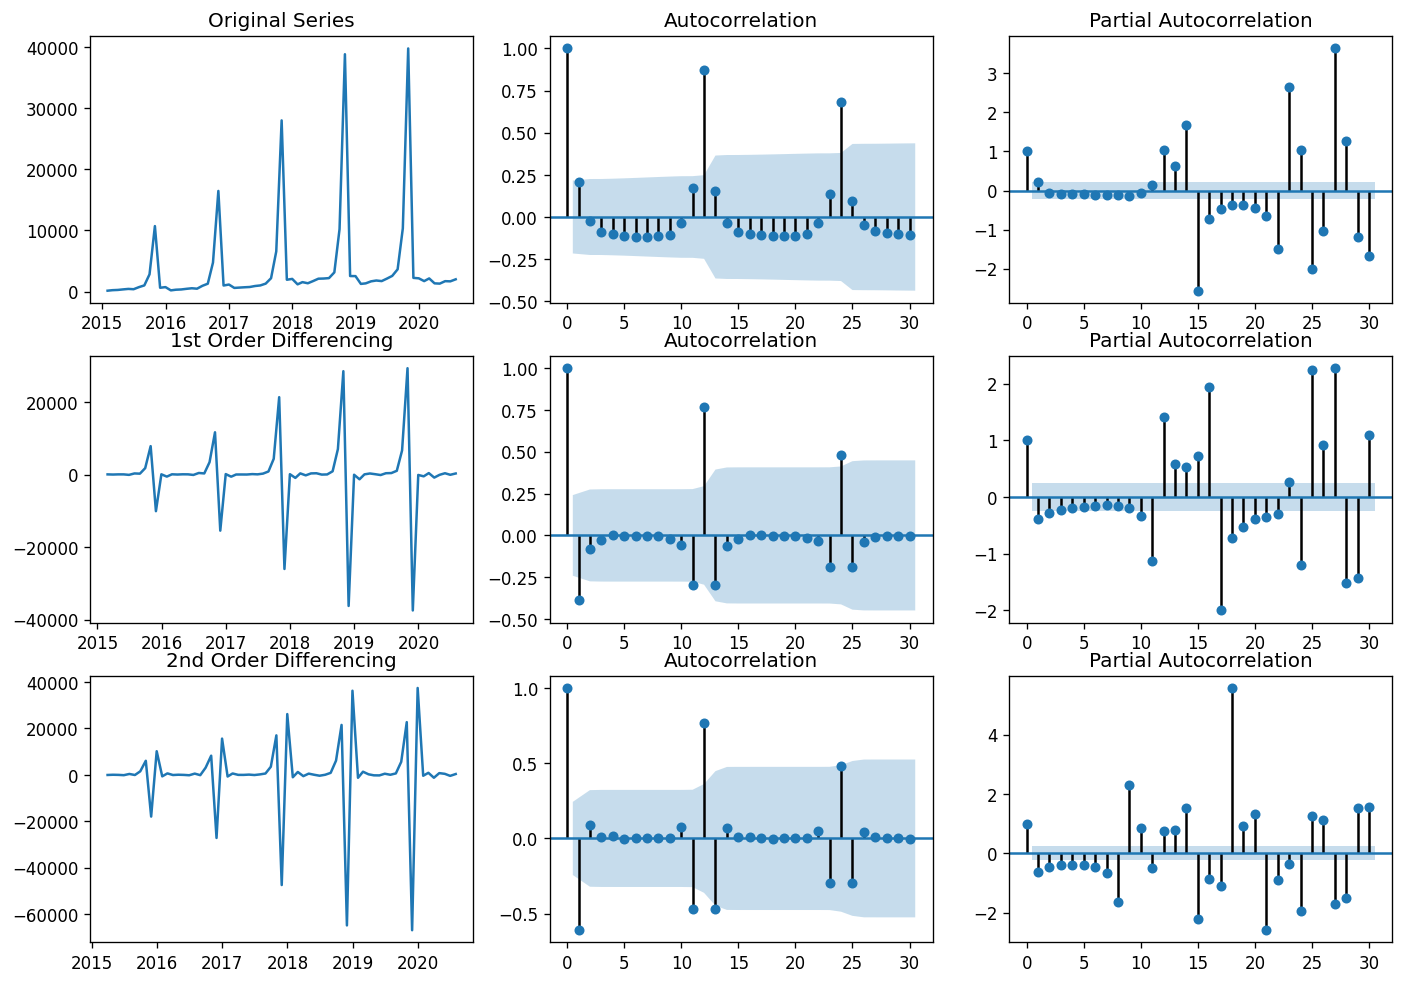

In [30]:
plt.rcParams.update({'figure.figsize':(14,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(train2.y); axes[0, 0].set_title('Original Series')
plot_acf(df.y, ax=axes[0, 1], lags=30)
plot_pacf(df.y, ax=axes[0, 2], lags=30)

# 1st Differencing
axes[1, 0].plot(train2.y.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train2.y.diff().dropna(), lags=30, ax=axes[1, 1])
plot_pacf(train2.y.diff().dropna(), lags=30, ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].plot(train2.y.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train2.y.diff().diff().dropna(), lags=30, ax=axes[2, 1])
plot_pacf(train2.y.diff().diff().dropna(), lags=30, ax=axes[2, 2])

plt.show()

Although the ACF\PACF graphs help us to get intuition on what should be the order of the parameters in the model, I'm building an objective function for finding a good combination of hyperparameters (hyperparameters tuning) using Bayesian optimization on a grid search space. \
For that task, I'm using [Optuna](https://optuna.readthedocs.io/en/stable/index.html#) which is an automatic hyperparameter optimization package.

I let the function search for 70 trails, and minimize the Mean Squared Errors (MSE) for model selection.

**Note:** because we already noticed we should differencing the series, I'm forcing the "d" parameter to be 1.

In [31]:
def objective(trial):
        
    d = trial.suggest_int('d',1, 2)
    p = trial.suggest_int('p',0, 6)
    q = trial.suggest_int('q',0, 6)
    
    D = trial.suggest_int('D',0, 1)
    P = trial.suggest_int('P',0, 2)
    Q = trial.suggest_int('Q',0, 1)
              
    
    model = SARIMAX(train2.y,
                  order=(p,d,q),
                  seasonal_order=(P,D,Q,12),
                  enforce_stationarity=False,
                  enforce_invertibility=False,
                  freq = 'M', 
                  maxiter=500)
            
    fitted = model.fit()
    pred = fitted.predict()
    mse = np.mean((train2.y - pred)**2)
    return mse

study = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=1234))
study.optimize(objective, n_trials=70)
best_params = study.best_params

print(best_params)

{'d': 1, 'p': 5, 'q': 6, 'D': 1, 'P': 1, 'Q': 1}


After we discovered the best parameters for the model, let's forecast the next two months for 2021.\
Then, let's plot the result and evaluate them.

In [32]:
# Build best model
d,p,q,D,P,Q = best_params.values()

model = SARIMAX(train.y,order=(p,d,q), seasonal_order=(P,D,Q,12), enforce_stationarity=False, enforce_invertibility=False, freq = 'M', maxiter=500)  
fitted = model.fit()  

# Forecast (out-of-sample)
sarima_test_pred = fitted.get_forecast(steps=2).summary_frame()
sarima_test_pred['y'] = sarima_test_pred['mean']
# Prediction (in-sample)
sarima_train_pred = fitted.predict()

# Make confidence interval seires
lower_series = sarima_test_pred['mean_ci_lower']
upper_series = sarima_test_pred['mean_ci_upper']

fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   80
Model:             SARIMAX(5, 1, 6)x(1, 1, 1, 12)   Log Likelihood                -426.709
Date:                            Fri, 28 Jan 2022   AIC                            881.419
Time:                                    14:53:20   BIC                            907.616
Sample:                                01-31-2015   HQIC                           891.319
                                     - 08-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8241      6.025     -0.137      0.891     -12.634      10.986
ar.L2         -0.6413      9.641     -0.067      0.947     -19.538      18.255
ar.L3         -0.3054      9.206     -0.033      0.974     -18.348      17.737
ar.L4         -0.1857      4.899     -0.038      0.970      -9.788       9.416
ar.L5         -0.5322      2.434     -0.219      0.827      -5.303       4.238
ma.L1          0.0957      6.063      0.016      0.987     -11.787      11.979
ma.L2         -0.0918      5.540     -0.017      0.987     -10.951      10.767
ma.L3         -0.3325      2.760     -0.120      0.904      -5.743       5.078
ma.L4         -0.1154      4.796     -0.024      0.981      -9.515       9.285
ma.L5          0.3208      4.875      0.066      0.948      -9.234       9.876
ma.L6         -0.4419      2.227     -0.198      0.843      -4.806       3.923
ar.S.L12       0.6552      0.159      4.127      0.000       0.344       0.966
ma.S.L12       0.0028      0.322      0.009      0.993      -0.629       0.634
sigma2      3.696e+06   3.04e-06   1.21e+12      0.000     3.7e+06     3.7e+06
===================================================================================
Ljung-Box (Q):                       29.02   Jarque-Bera (JB):                89.47
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             1.05
Prob(H) (two-sided):                  0.08   Kurtosis:                         9.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.53e+29. Standard errors may be unstable.
"""

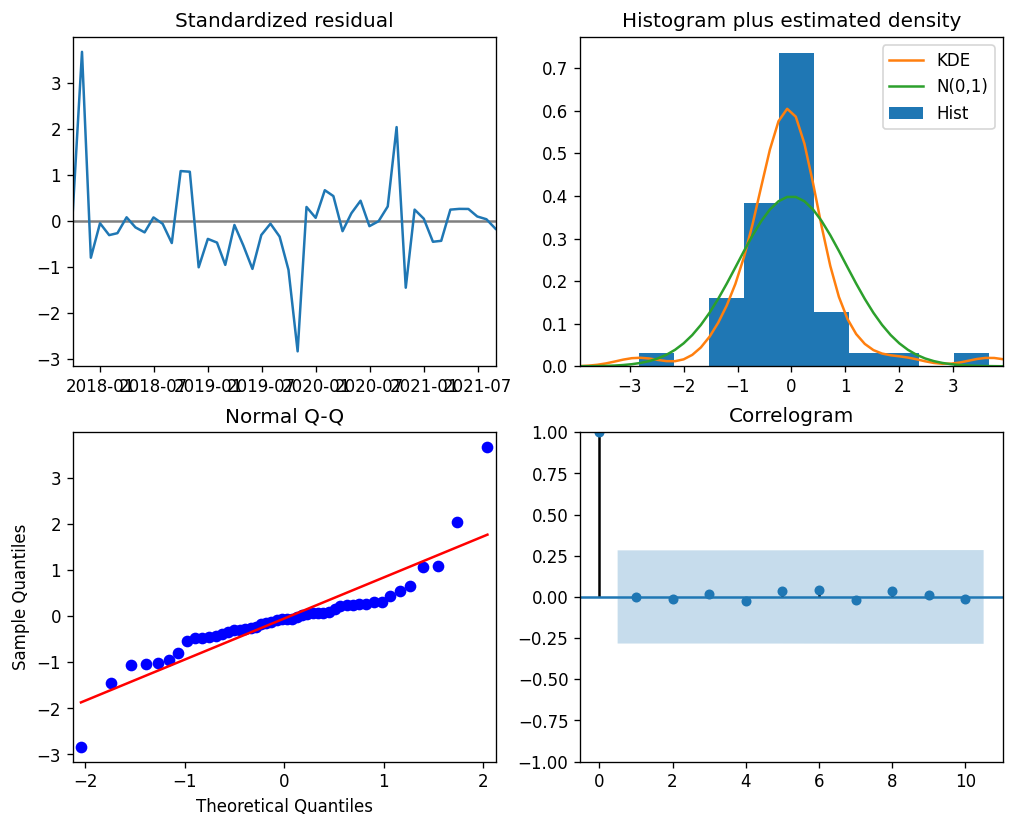

In [33]:
fitted.plot_diagnostics(figsize=(10,8))
plt.show()

In [34]:
make_graph(test_pred=sarima_test_pred.y, test=test.y, dates=test.index,
           train_pred=sarima_train_pred, train=train, with_train=True,
           with_boundries = True, lower_series=lower_series, upper_series=upper_series)

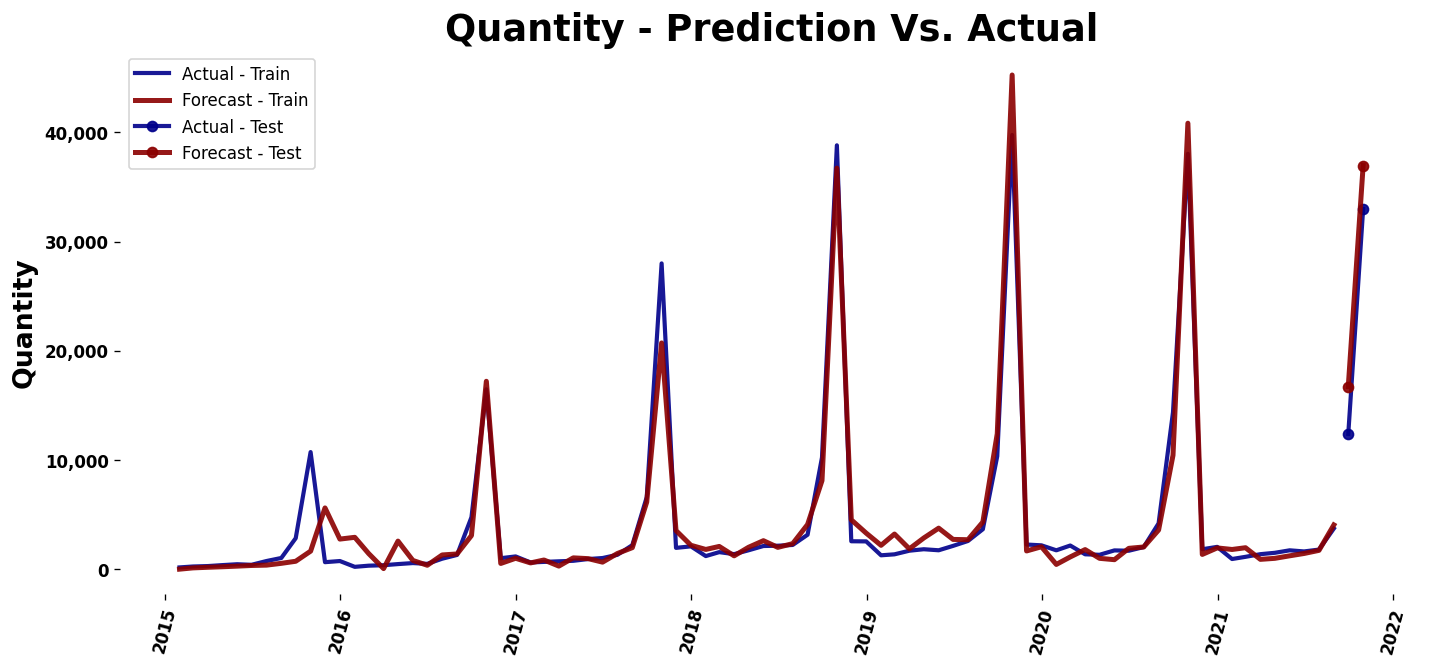

In [35]:
make_graph2(test_pred=sarima_test_pred.y, test=test.y, test_dates=test.index,
           train_pred=sarima_train_pred, train=train, train_dates=train.index, with_train=True)

In [36]:
temp = evaluation(sarima_test_pred.y.values,test.y.values, is_print=True)

Total Predicted Quantity: 53671 

Total Actual Quantity: 45377.0 

Total Period Error: 8294 

Total Period % Error: 18.3 % 

MAE: 4147.151 

RMSE: 4151.2495 

MAPE: 23.4964 %


The predictions are in months intervals, in order to convert the into days interval, we will use the months_to_days function and assume that the distribution in 2021 will be the same as in 2020.

In [37]:
df,holidays_data = import_data(freq='D')
train,test = split(df)
sarima_test_pred = months_to_days(sarima_test_pred.y)

In [38]:
temp = evaluation(sarima_test_pred,test.y, is_print=True)

Total Predicted Quantity: 53671 

Total Actual Quantity: 45437.0 

Total Period Error: 8234 

Total Period % Error: 18.099999999999998 % 

MAE: 138.813 

RMSE: 207.1852 

MAPE: 18.9691 %


In [39]:
make_graph(sarima_test_pred, test.y, test.index)

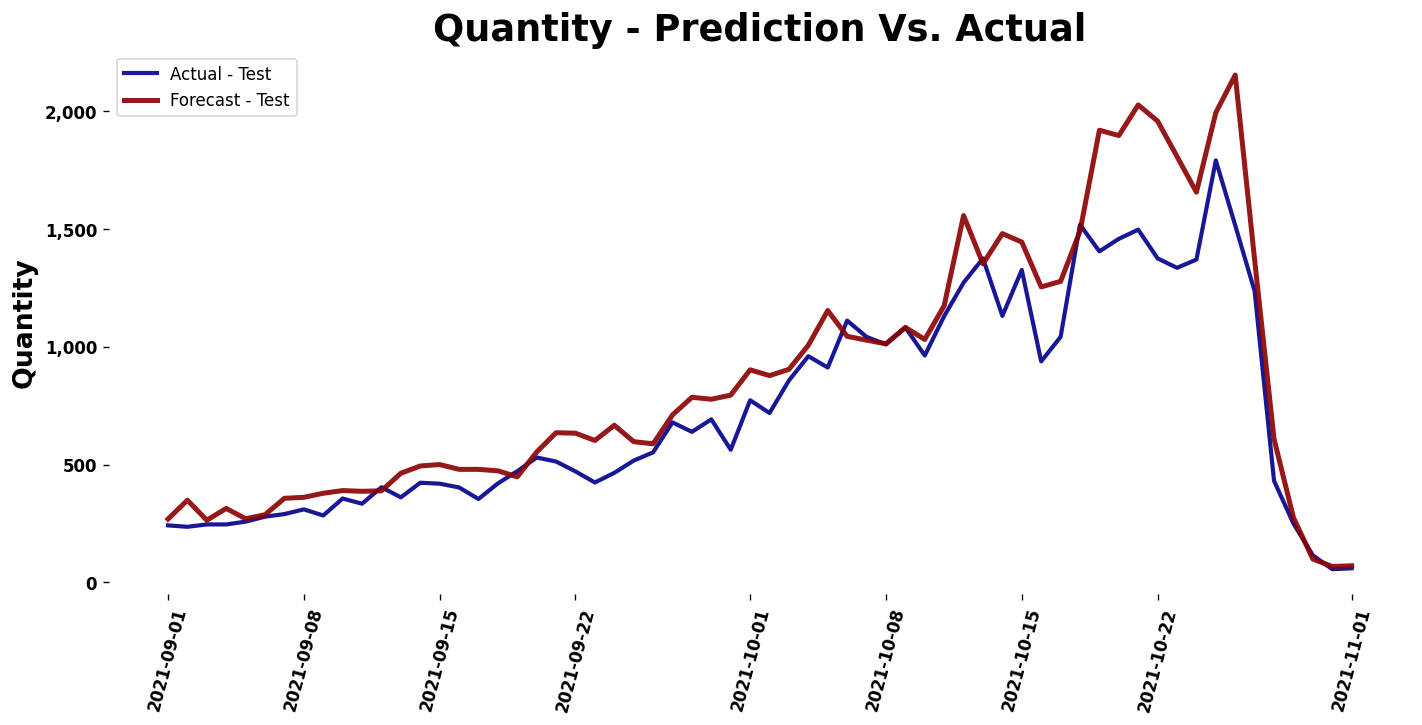

In [40]:
make_graph2(sarima_test_pred,test.y,test.index)

# GAM - Generalized  Additive Model

When we try to forecast 2 months ahead, in terms of daily periods it's 61 periods ahead. Forecast so deep into the future could be a difficult challenge for any type of model. This is why we should check models that don't depend on the lag variable like the autoregressive model (AR) and we can try the **Generalized additive model (GAM)** approach.

I assume the demand is exogenous and it depends mainly on the proximity of the current date to the event (Halloween). Usually, people buy Halloween products as the event approaches, so this is a reasonable assumption that can be seen in the data even without prior knowledge of the business.

The model is:

$G(E(sales)) = \beta_0 + f_1(Year) + f_2(Month) + f_3(Weekday) + f_4(Dist\_ From\_Event)$

Now we import the data but this time we are using the holiday's dataset for the holiday dates (31/10 / YYY).
Please notice we are using daily data for this model.

In addition, we know the peak of the event in terms of units sold is roughly 3 days before the event itself. Therefore, we fixed the date of the event for the "dist_from_halloween" variable we are going to generate.

In [41]:
df,holidays_data = import_data(freq='D')

In [42]:
halloween = holidays_data[holidays_data['holiday'] == "Halloween"]
halloween['ds'] = halloween['ds']- dt.timedelta(3) # the pick is 3 days before
halloween['year'] = pd.DatetimeIndex(halloween['ds']).year.copy()
halloween.reset_index(inplace=True)

Here, we create features for the model. 

In [43]:
# dist_from_halloween variable
halloween = df.merge(halloween['ds'],how='left', left_on=df.index.year, right_on=halloween['ds'].dt.year)['ds']
df['halloween'] = halloween.values
df['dist_from_halloween'] = (df.index - df.halloween).dt.days
df['dist_from_halloween'].apply(lambda x: x-365 if x > 0 else x)

df['ds'] = df.index
# weekday variable
df['weekday'] = df['ds'].dt.weekday

# month variable
df['month'] = df['ds'].dt.month

# year variable
df['year'] = df['ds'].dt.year

In [44]:
train,test = split(df)

## Box and Cox transformation
train.y,lam = scipy.stats.boxcox(train.y + 1e-08) 

train2, val = split(train, test_date='2020-08-31')

In this model, the hyperparameters are:
- n_splines: The number of splines that build the variable series (high number allows the model to be more complex).
- lam: Lambda, is the regularization parameter. restrict the model from being with too much "wiggliness".  

In [45]:
%%time
# Hyperparameter tuning
X, y = train2[['year','dist_from_halloween','weekday','month']].values, train2['y'].values

X_val, y_val = val[['year','dist_from_halloween','weekday','month']].values, val['y'].values

def objective(trial):

  n_splines = trial.suggest_int('n_splines',100, 500)
  lam = trial.suggest_float("lam", 1e-3, 1e+3, log=True)
          
  # modeling
  gam = LinearGAM(n_splines = n_splines).gridsearch(X, y,lam=[lam]*X.shape[1])   
  predictions = gam.predict(val[['year','dist_from_halloween','weekday','month']].values)
               
  return np.mean(np.abs(val.y - predictions))

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=1234))
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best Parameters: ",best_params)

100% (4 of 4) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (4 of 4) |##########################| Elapsed Time: 0:00:19 Time:  0:00:19
100% (4 of 4) |##########################| Elapsed Time: 0:00:53 Time:  0:00:53
100% (4 of 4) |##########################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (4 of 4) |##########################| Elapsed Time: 0:01:23 Time:  0:01:23
100% (4 of 4) |##########################| Elapsed Time: 0:00:13 Time:  0:00:13
100% (4 of 4) |##########################| Elapsed Time: 0:00:41 Time:  0:00:41
100% (4 of 4) |##########################| Elapsed Time: 0:00:14 Time:  0:00:14
100% (4 of 4) |##########################| Elapsed Time: 0:00:22 Time:  0:00:22
100% (4 of 4) |##########################| Elapsed Time: 0:00:52 Time:  0:00:52
100% (4 of 4) |##########################| Elapsed Time: 0:01:23 Time:  0:01:23
100% (4 of 4) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (4 of 4) |#########################

Best Parameters:  {'n_splines': 372, 'lam': 37.04068070948873}
CPU times: user 1h 49min 28s, sys: 12min 55s, total: 2h 2min 23s
Wall time: 1h 3min 43s


100% (4 of 4) |##########################| Elapsed Time: 0:00:41 Time:  0:00:41


CPU times: user 1min 10s, sys: 8.09 s, total: 1min 19s
Wall time: 41.2 s


<Figure size 1680x1200 with 0 Axes>

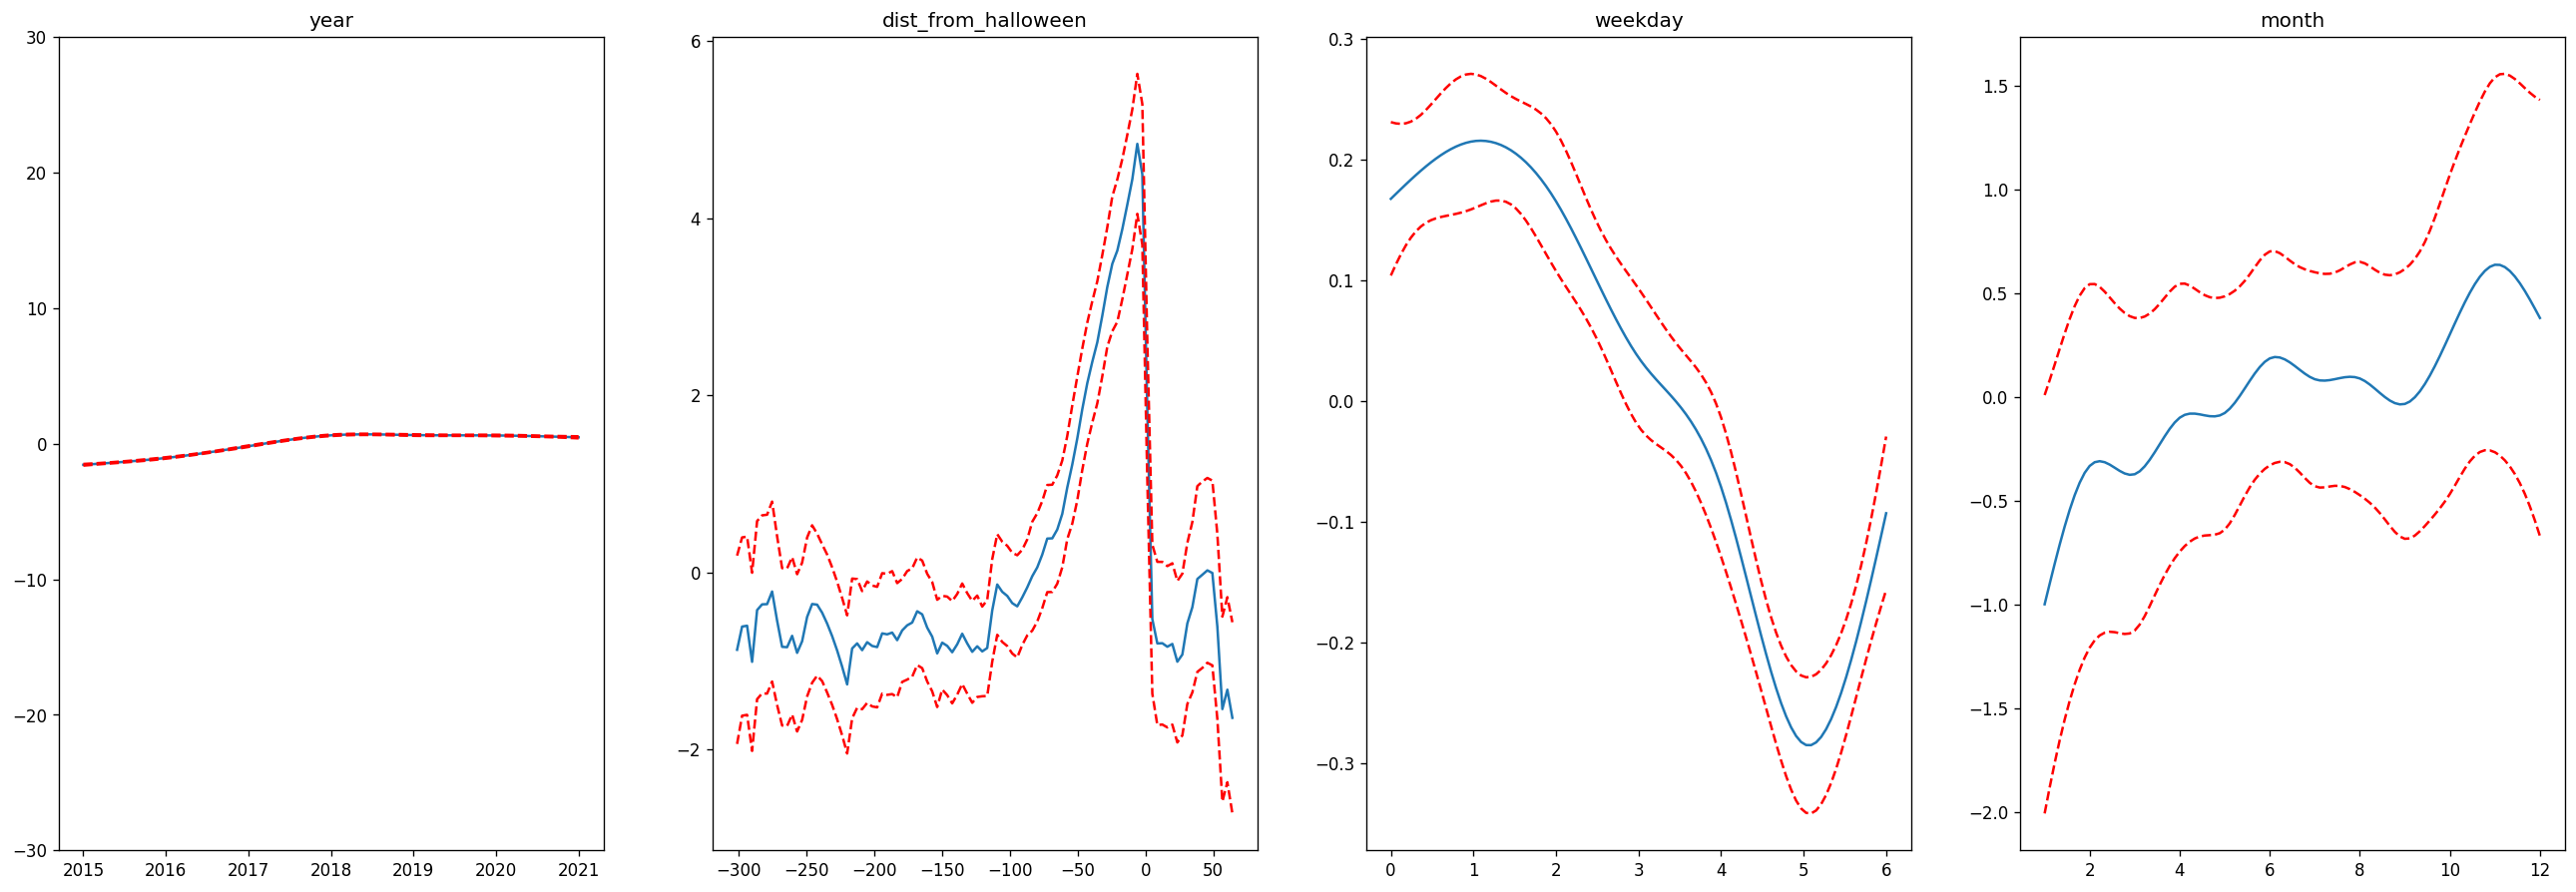

In [46]:
%%time
## Final model
X, y = train[['year','dist_from_halloween','weekday','month']].values,train['y'].values
gam = LinearGAM(n_splines=best_params.get('n_splines')).gridsearch(X, y,lam=[best_params.get('lam')]*X.shape[1])


## plotting
plt.figure();
plt.rcParams["figure.figsize"] = (27,9)
fig, axs = plt.subplots(1,X.shape[1]);

titles = ['year','dist_from_halloween','weekday','month']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

In [47]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    102.8279
Link Function:                     IdentityLink Log Likelihood:                                 -2994.7882
Number of Samples:                         2435 AIC:                                             6197.2323
                                                AICc:                                            6206.5741
                                                GCV:                                                0.3867
                                                Scale:                                              0.3575
                                                Pseudo R-Squared:                                   0.8983
Feature Function                  Lam

In [48]:
gam_test_pred = gam.predict(test[['year','dist_from_halloween','weekday','month']].values)
gam_train_pred = gam.predict(train[['year','dist_from_halloween','weekday','month']].values)

# Inverse Box and Cox transformation
train['y'] = scipy.special.inv_boxcox(train['y'], lam)
gam_test_pred = scipy.special.inv_boxcox(gam_test_pred, lam)
gam_train_pred = scipy.special.inv_boxcox(gam_train_pred, lam)

pd.Series(gam_train_pred).fillna(0,inplace=True) # For NAs values

In [49]:
make_graph(gam_train_pred, train.y, train.index)

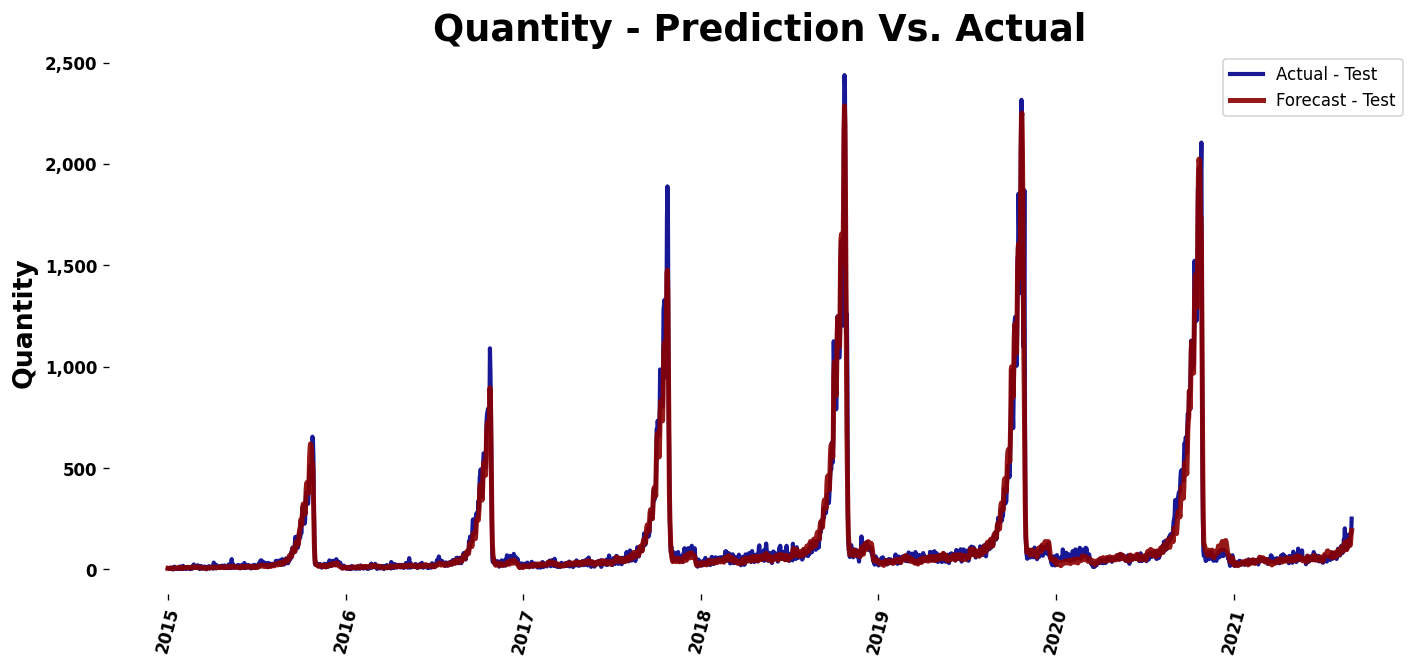

In [50]:
make_graph2(gam_train_pred, train.y, train.index)

In [51]:
temp = evaluation(gam_train_pred,train.y, is_print=True)

Total Predicted Quantity: 314427 

Total Actual Quantity: 320225.00002436055 

Total Period Error: -5798 

Total Period % Error: -1.7999999999999998 % 

MAE: 20.102 

RMSE: 49.0088 

MAPE: 45795414.2276 %


In [52]:
make_graph(gam_test_pred, test.y, test.index)

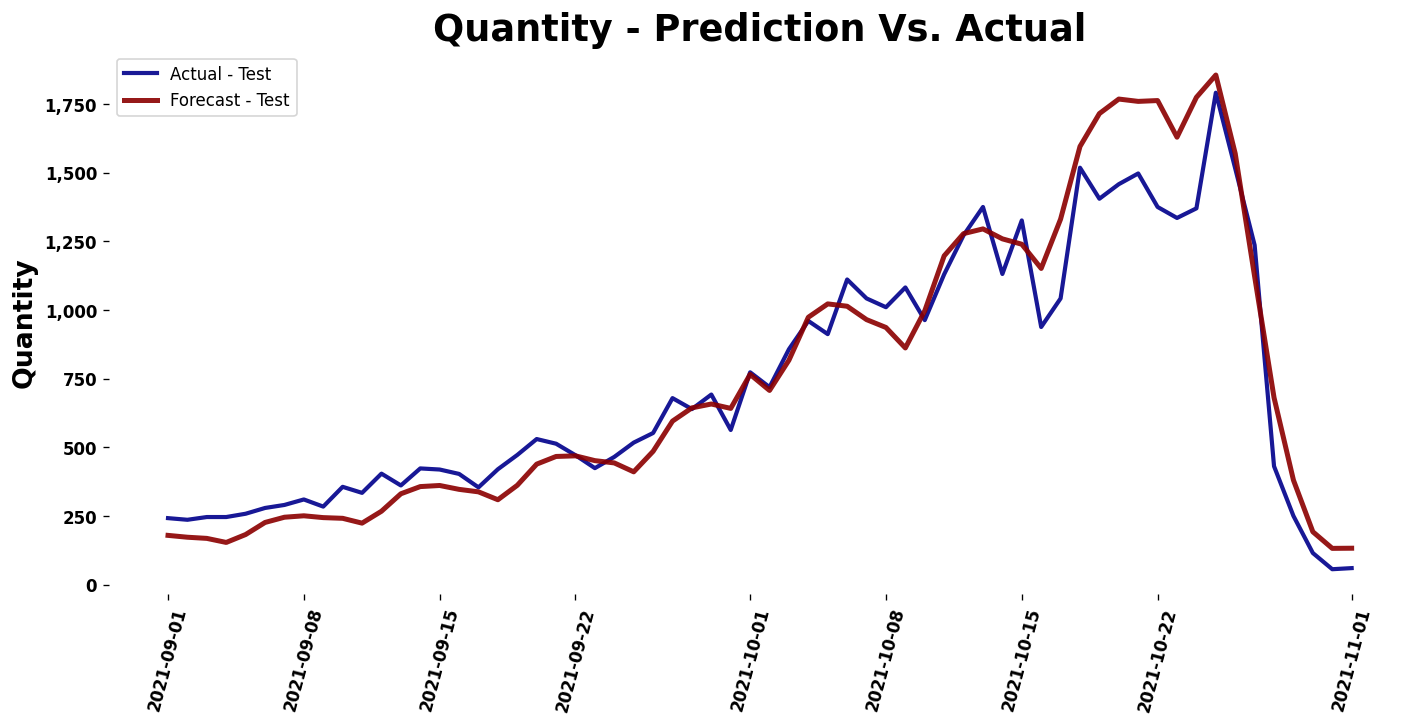

In [53]:
make_graph2(gam_test_pred, test.y, test.index)

In [54]:
temp = evaluation(gam_test_pred,test.y, is_print=True)

Total Predicted Quantity: 46537 

Total Actual Quantity: 45437.0 

Total Period Error: 1100 

Total Period % Error: 2.4 % 

MAE: 102.961 

RMSE: 138.711 

MAPE: 20.5078 %


# Facebook Prophet Model

The next model uses the **Generalized additive model (GAM)** approach as well. \\
[Prophet](https://facebook.github.io/prophet/) is open source software released by Facebook’s Core Data Science team.

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with: yearly, weekly, and daily seasonality, plus holiday effects. 

It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

At its core is the sum of three functions of time plus an error term: growth $g(t)$, seasonality $s(t)$, holidays $h(t)$ , and error $e$ :  \\


**$y(t) = g(t) + s(t) + h(t) + e$**

\\

The **growth function ($g(t)$)** models the overall trend of the data. The growth trend can be present at all points in the data or can be altered at what Prophet calls “changepoints” -  moments in the data where the data shifts direction.

\\

The **seasonality function ($s(t)$)** is a Fourier Series as a function of time:

\\

**$s(t) = \sum_{n=1}^N (a_n cos (\frac{2\pi nt}P) + b_n sin (\frac{2\pi nt}P))$**

\\

The **holiday function ($h(t)$)** allows Facebook Prophet to adjust forecasting when a holiday or major event may change the forecast. It takes a list of dates and creates dummy variables for them and their upper/lower window dates.



In [55]:
# Import the data
df,holidays_data = import_data(freq='D')
df['ds'] = pd.to_datetime(df.index)
holidays_data = holidays_data.loc[holidays_data['holiday']== "Halloween"]

# Split the data into train and test sets
train,test = split(df)

# Box and Cox transformation
train.y, lam = scipy.stats.boxcox(train.y + 1e-08) # adding small constant for days without sales
train = train.dropna()

In [56]:
%%time
def objective(trial):

  params_grid = {  'changepoint_prior_scale' : trial.suggest_float('changepoint_prior_scale',0.01, 0.6),
                   'holidays_prior_scale' : trial.suggest_int('holidays_prior_scale',10,100),
                   'seasonality_prior_scale' : trial.suggest_float('seasonality_prior_scale',0.0, 50),
                   'n_changepoints' : trial.suggest_int('n_changepoints',25, 100),
                   'changepoint_range': trial.suggest_float('changepoint_range',0.6, 0.99),               
                   'yearly_seasonality' : trial.suggest_int('yearly_seasonality',10,40)
                }
  
  # modeling
  m = Prophet(holidays=holidays_data,**params_grid)
  m.fit(train) 
  cutoffs = pd.to_datetime(['2020-08-31','2019-08-31'])
  df_cv = cross_validation(m, cutoffs=cutoffs, horizon='65 days',parallel="processes")
  df_p = performance_metrics(df_cv, rolling_window=1)
    
  return df_p['mae'].values[0]

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=1234))
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best Parameters: ",best_params) 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f59f7dbf8d0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f59f7e0cc10>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f59f7db4910>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f59f7d32b90>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in par

Best Parameters:  {'changepoint_prior_scale': 0.41450441720850423, 'holidays_prior_scale': 35, 'seasonality_prior_scale': 42.97093520494902, 'n_changepoints': 67, 'changepoint_range': 0.931785975662943, 'yearly_seasonality': 37}
CPU times: user 33min 52s, sys: 47.2 s, total: 34min 40s
Wall time: 1h 19min 47s


In [57]:
# Train the model     
m = Prophet(holidays=holidays_data,**best_params)
m.fit(train)
future = m.make_future_dataframe(periods=365,freq='D')
forecast = m.predict(future)  

# Inverse Box and Cox transformation
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: scipy.special.inv_boxcox(x, lam))
train['y'] = scipy.special.inv_boxcox(train['y'], lam)
m.history['y'] = m.history['y'].apply(lambda x: scipy.special.inv_boxcox(x, lam))


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [58]:
prophet_train_pred = forecast.loc[(forecast.ds <= '2021-08-31'),['ds','yhat']]
prophet_test_pred = forecast.loc[(forecast.ds > '2021-08-31') & (forecast.ds <= '2021-11-01'),'yhat'].values

In [59]:
make_graph(forecast.yhat[forecast.ds <= '2021-08-31'],train['y'],train['ds'])

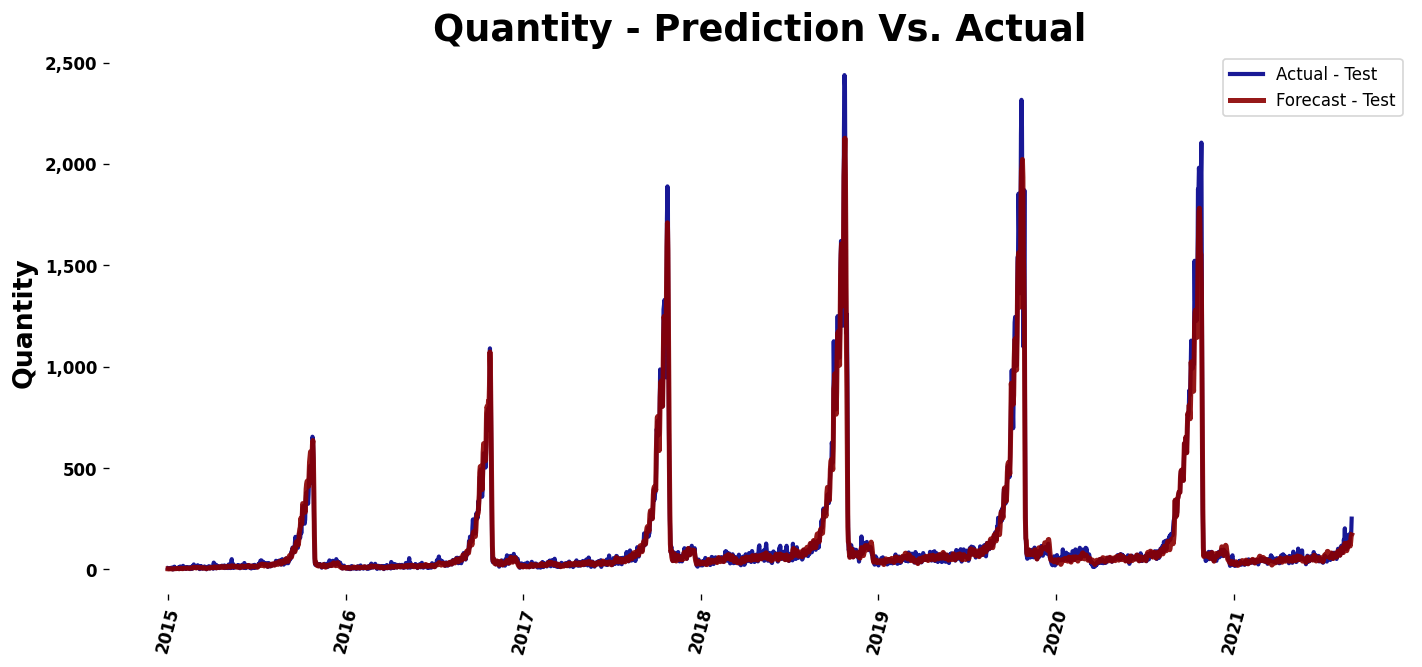

In [60]:
make_graph2(forecast.yhat[forecast.ds <= '2021-08-31'],train['y'],train['ds'])

In [61]:
temp = evaluation(prophet_train_pred.yhat.fillna(0).values,train.y.values, is_print=True)

Total Predicted Quantity: 312252 

Total Actual Quantity: 320225.00002436055 

Total Period Error: -7973 

Total Period % Error: -2.5 % 

MAE: 17.153 

RMSE: 44.4774 

MAPE: 28547366.1452 %


In [62]:
make_graph(prophet_test_pred,test['y'],test['ds'])

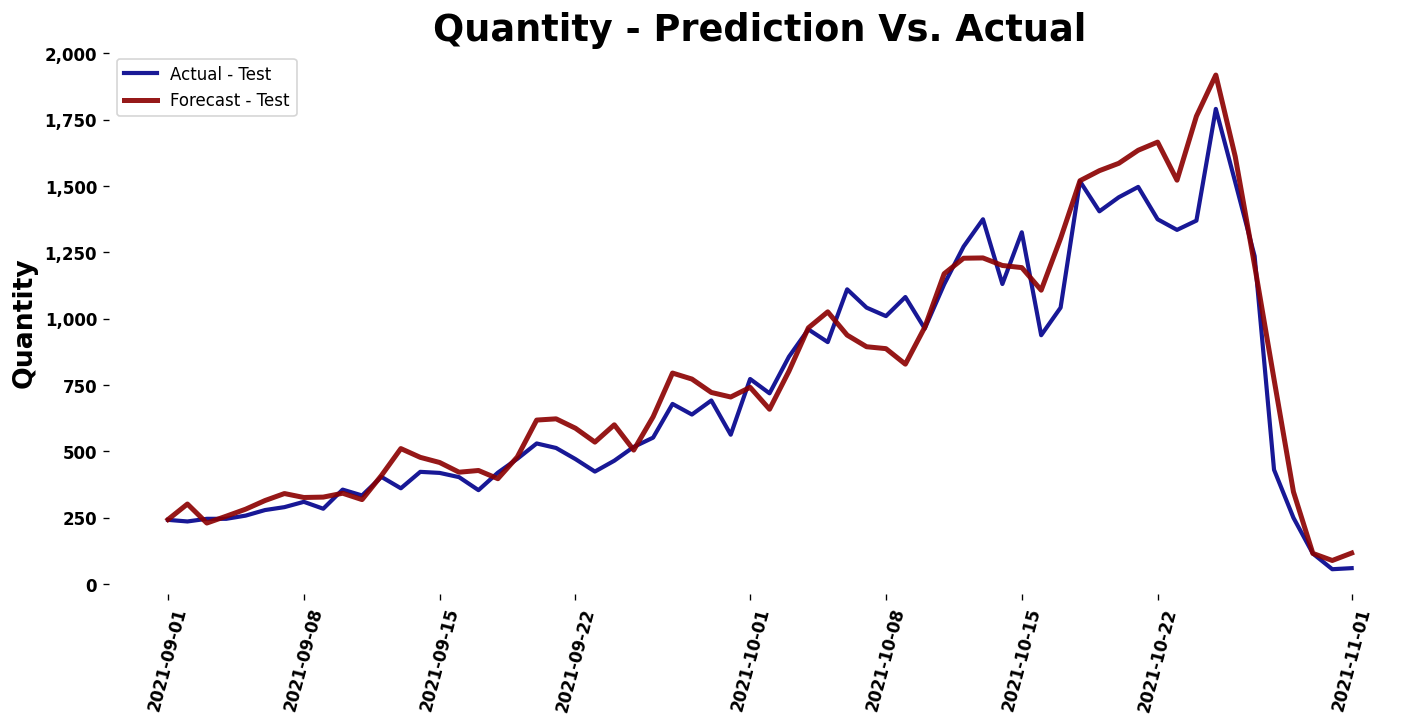

In [63]:
make_graph2(prophet_test_pred,test['y'],test['ds'])

In [64]:
temp = evaluation(prophet_test_pred,test.y.values, is_print=True)

Total Predicted Quantity: 48528 

Total Actual Quantity: 45437.0 

Total Period Error: 3091 

Total Period % Error: 6.800000000000001 % 

MAE: 91.132 

RMSE: 124.04 

MAPE: 15.5469 %


#ML Models

###**Models**
In this Section we will use these models: 
- Linear Regression
- Lasso
- Ridge
- ElasticNet
- KNN
- SVR
- Decision Tree
- Random Forest
- XGBoost

I'm using [Scikit-Learn](https://scikit-learn.org/stable/) implementation for all the models except [XGBoost](https://xgboost.readthedocs.io/en/stable/). \
The time interval will be in months. 

###**Multi-Step Ahead Forecast**
In order to predict 2 months ahead I'm using [RegressorChain](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.RegressorChain.html) method in Scikit-Learn.

Each model makes a prediction in the order specified by the chain using all of the available features provided to the model plus the predictions of models that are earlier in the chain.


###**Hyperparameter Tuning:**
For hyperparameter tuning I'm using [Otuna](https://optuna.org/) optimization framework, using bayesian optimization approche for hyperparameter tuning on large search grid space.  

###**Cross Validation:**
Time Series cross-validator - [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit): 
Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set. 

In [65]:
df,holidays_data = import_data('M')

### Feature Engineering

In [66]:
# Create sales growth rate features and lag varibles by shifting values by 'i' number of time periods
look_back = 12
df['rate'] = df['y']/df['y'].shift(1)
for i in range(1, look_back+1):
    label = ''.join(['rate_lag', str(i+1)])
    df['rate '+'lag'+str(i)] = df['rate'].shift(i) 

# Create targets and features by shifting values by 'i' number of time periods
look_back = 12
for i in range(1, look_back+1):
    label = ''.join(['y_lag', str(i+1)])
    df['y '+'lag'+str(i)] = df['y'].shift(i) 

df = df.dropna()

df['ds'] = df.index
# month variable
df['month'] = df['ds'].dt.month

# year variable
df['year'] = df['ds'].dt.year
df.drop(columns = ['ds'], inplace=True)

# One-Hot encoding for multi-category variables
df = create_dummies(df, 'year')
df = create_dummies(df, 'month')

# Create forecast periods (t and t+1)
df['y+1'] = df.y.shift(-1)
df['y new'] = np.vstack((df['y'],df['y+1'])).T.tolist()
df = df.replace(np.inf,np.nan)
df.dropna(inplace=True)

### Split the dataset into train and test and scaling transformation

In [67]:
train,test = split(df)
X_train, y_train = train[train.columns[1:-1].tolist()].values, train[train.columns[-1]].values
X_test, y_test = test[test.columns[1:-1].tolist()].values, test[test.columns[-1]].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.tolist())

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.tolist())

### Models

In [68]:
# Define models
lr = LinearRegression() 
lasso = Lasso()
ridge = Ridge()
elnet = ElasticNet()
knn = KNeighborsRegressor()
svr = SVR()                     
dtr = DecisionTreeRegressor()
rf = RandomForestRegressor()
xgb = XGBRegressor(verbosity = 0)

In [69]:
models = [lr, lasso, ridge, elnet, knn, svr, dtr, rf, xgb]

for model in models:
  
    name = model.__class__.__name__
    time_split = TimeSeriesSplit(n_splits=15)
    ChainRegression= RegressorChain(model, order=[0, 1]).fit(X_train_scaled, y_train_scaled)
    result = cross_val_score(ChainRegression,X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=time_split, n_jobs=-1)
    print(f"{name}\'s score: {round(-result.mean(),5)}")

LinearRegression's score: 0.04275
Lasso's score: 0.11414
Ridge's score: 0.0445
ElasticNet's score: 0.11414
KNeighborsRegressor's score: 0.06786
SVR's score: 0.12082
DecisionTreeRegressor's score: 0.04516
RandomForestRegressor's score: 0.04556
XGBRegressor's score: 0.05866


### Hyperparameter Tuning

#### Grid search for bayesian optimization, create objective functions

In [70]:
# Lasso Regression
def objective_lasso(trial):
  params_grid = {
      'alpha': trial.suggest_float('alpha',0,1),
      'fit_intercept' : trial.suggest_categorical('fit_intercept',[True,False])

  }
  model = Lasso(**params_grid)
  ChainRegression = RegressorChain(model, order=[0, 1]).fit(X_train_scaled, y_train_scaled)
  time_split = TimeSeriesSplit(n_splits=20)
  result = cross_val_score(ChainRegression, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=time_split, n_jobs=-1)
    
  return -result.mean()

# Ridge Regression

def objective_ridge(trial):
  params_grid = {
      'solver': trial.suggest_categorical('solver',['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
      'alpha': trial.suggest_float('alpha',0,1),
      'fit_intercept' : trial.suggest_categorical('fit_intercept',[True,False])

  }
  model = Ridge(**params_grid)
  ChainRegression = RegressorChain(model, order=[0, 1]).fit(X_train_scaled, y_train_scaled)
  time_split = TimeSeriesSplit(n_splits=20)
  result = cross_val_score(ChainRegression, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=time_split, n_jobs=-1)
    
  return -result.mean()


# ElasticNet Regression

def objective_elnet(trial):
  params_grid = {
      'alpha': trial.suggest_float('alpha',0,1),
      'l1_ratio': trial.suggest_float('l1_ratio',0,1),
      'fit_intercept' : trial.suggest_categorical('fit_intercept',[True,False])
      
  }
  model = ElasticNet(**params_grid)
  ChainRegression = RegressorChain(model, order=[0, 1]).fit(X_train_scaled, y_train_scaled)
  time_split = TimeSeriesSplit(n_splits=20)
  result = cross_val_score(ChainRegression, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=time_split, n_jobs=-1)
    
  return -result.mean()



# K Nearest Neighbors

def objective_knn(trial):
  params_grid = {
     'n_neighbors': trial.suggest_int('n_neighbors', 1, 5),
     'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
     'algorithm': trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree', 'brute']),
     'leaf_size': trial.suggest_int('leaf_size', 2, 30),
     'p': trial.suggest_int('p', 1,2)
  }
  model = KNeighborsRegressor(**params_grid)
  ChainRegression = RegressorChain(model, order=[0, 1]).fit(X_train_scaled, y_train_scaled)
  time_split = TimeSeriesSplit(n_splits=20)
  result = cross_val_score(ChainRegression, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=time_split, n_jobs=-1)
    
  return -result.mean()


# Support Vector Regression

def objective_svr(trial):
  params_grid = {
      'C': trial.suggest_loguniform('C', 1e-9, 1e2),
      'gamma': trial.suggest_loguniform('gamma', 1e-9, 1e2),
  }
  model = SVR(kernel='rbf', **params_grid)
  ChainRegression = RegressorChain(model, order=[0, 1]).fit(X_train_scaled, y_train_scaled)
  time_split = TimeSeriesSplit(n_splits=20)
  result = cross_val_score(ChainRegression, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=time_split, n_jobs=-1)
    
  return -result.mean()


# Decision Tree

def objective_dtr(trial):
  params_grid = {
      'max_features':  trial.suggest_int('max_features',1, X_train.shape[1]),
      'max_depth': trial.suggest_int('max_depth', 3, 10),
      'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 1.0, step=0.01)
  }
  model = DecisionTreeRegressor(**params_grid)
  ChainRegression = RegressorChain(model, order=[0, 1]).fit(X_train_scaled, y_train_scaled)
  time_split = TimeSeriesSplit(n_splits=20)
  result = cross_val_score(ChainRegression, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=time_split, n_jobs=-1)
    
  return -result.mean()



# Random Forest

def objective_rf(trial):
  params_grid = {
      'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
      'max_features':  trial.suggest_int('max_features', 1, X_train.shape[1]),
      'max_depth': trial.suggest_int('max_depth', 3, 20),
      'min_samples_split': trial.suggest_float('min_samples_split', 0.0001, 1.0, step=0.0001),
  }
  model = RandomForestRegressor(**params_grid)
  ChainRegression = RegressorChain(model, order=[0, 1]).fit(X_train_scaled, y_train_scaled)
  time_split = TimeSeriesSplit(n_splits=20)
  result = cross_val_score(ChainRegression, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=time_split, n_jobs=-1)
    
  return -result.mean()



# Xgboost

def objective_xgb(trial):
  params_grid = {
      'learning_rate': trial.suggest_float('learning_rate', 1e-5, 5e-1, log=True),
      'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
      'eta': trial.suggest_float('eta', 5e-3, 5e-1),
      'gamma': trial.suggest_float('gamma', 0, 10),
      'max_depth': trial.suggest_int('max_depth', 3, 20),
      'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5 ,1, step=0.25)
  }
  model = XGBRegressor(verbosity=0,**params_grid)
  ChainRegression = RegressorChain(model, order=[0, 1]).fit(X_train_scaled, y_train_scaled)
  time_split = TimeSeriesSplit(n_splits=20)
  result = cross_val_score(ChainRegression, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=time_split, n_jobs=-1)
    
  return -result.mean()

In [71]:
%%time
models = [lasso, ridge, elnet, knn, svr, dtr, rf, xgb]

objectives = [objective_lasso, objective_ridge, objective_elnet, objective_knn, objective_svr, objective_dtr, objective_rf, objective_xgb]

for model, objective in list(zip(models, objectives)):
    name = model.__class__.__name__

    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=1234))
    study.optimize(objective, n_trials=250)
    
    globals()[str(name)+'_best_params'] = study.best_params
    best_params = study.best_params
    best_value = study.best_value
    best_trail = study.best_trial.number
        
    print('Model:', name,'\n')
    print('Best Trial:' ,best_trail,'\n')
    print('Best Score: ', round(best_value, 5),'MAE.\n')
    print('Best Params:', best_params)
    print('=========================================================================================================================================')



Model: Lasso 

Best Trial: 168 

Best Score:  0.02369 MAE.

Best Params: {'alpha': 0.0002818357862808324, 'fit_intercept': True}
Model: Ridge 

Best Trial: 119 

Best Score:  0.0341 MAE.

Best Params: {'solver': 'cholesky', 'alpha': 0.09048185657826438, 'fit_intercept': True}
Model: ElasticNet 

Best Trial: 232 

Best Score:  0.02486 MAE.

Best Params: {'alpha': 0.00015948036519694065, 'l1_ratio': 0.4614560919770669, 'fit_intercept': False}
Model: KNeighborsRegressor 

Best Trial: 20 

Best Score:  0.03249 MAE.

Best Params: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 17, 'p': 1}
Model: SVR 

Best Trial: 128 

Best Score:  0.07111 MAE.

Best Params: {'C': 97.07177831112755, 'gamma': 0.0019065601774550234}
Model: DecisionTreeRegressor 

Best Trial: 165 

Best Score:  0.03759 MAE.

Best Params: {'max_features': 19, 'max_depth': 6, 'min_samples_split': 0.05}
Model: RandomForestRegressor 

Best Trial: 144 

Best Score:  0.04363 MAE.

Best Params: {'n_est

In [72]:
# Define models with the best hyperparameters
lasso = Lasso(**Lasso_best_params)
ridge = Ridge(**Ridge_best_params)
elnet = ElasticNet(**ElasticNet_best_params)
knn = KNeighborsRegressor(**KNeighborsRegressor_best_params)
svr = SVR(**SVR_best_params)                     
dtr = DecisionTreeRegressor(**DecisionTreeRegressor_best_params)
rf = RandomForestRegressor(**RandomForestRegressor_best_params)
xgb = XGBRegressor(**XGBRegressor_best_params, verbosity = 0)

models = [lasso, ridge, elnet, knn, svr, dtr, rf, xgb]
for model in models:
  name = model.__class__.__name__
  ChainRegression= RegressorChain(model, order=[0, 1]).fit(X_train_scaled, y_train_scaled)
  globals()[str(name)+'_pred'] = ChainRegression.predict(X_test_scaled)
  
  # Inverse the scaling transformtion
  globals()[str(name)+'_pred'] = scaler_y.inverse_transform(globals()[str(name)+'_pred'])
  
  # Convert the time intervals from months into days based on last year distribution using the months_to_days function I made  
  globals()[str(name)+'_test_pred']= months_to_days(globals()[str(name)+'_pred'])
  print('Total' ,str(name)+'_test_pred quantity:', round(globals()[str(name)+'_pred'].sum()))



Total Lasso_test_pred quantity: 47510
Total Ridge_test_pred quantity: 50514
Total ElasticNet_test_pred quantity: 49069
Total KNeighborsRegressor_test_pred quantity: 52401
Total SVR_test_pred quantity: 45682
Total DecisionTreeRegressor_test_pred quantity: 53235
Total RandomForestRegressor_test_pred quantity: 50925
Total XGBRegressor_test_pred quantity: 50937


# Evaluation and Comparison

A quick reminder, the goal is to predict the total quantity we are going to sell in the next 2 months on the Halloween event. \
With that in mind, let's compare all the models' predictions for Halloween 2020 (when it was the test set) and Halloween 2021. 

### Create The Datasets

In [73]:
df,holidays_data = import_data('D',last_date='2021-11-01')

# 2020 predicitons
predictions = pd.DataFrame({'Prophet': prophet_test_pred,
                            'Holt-Winters': holt_test_pred,
                              'SARIMA': sarima_test_pred,
                              'GAM': gam_test_pred,
                              'ElasticNet': ElasticNet_test_pred,
                              'Lasso': Lasso_test_pred,
                              'Ridge': Ridge_test_pred,
                              'SVR': SVR_test_pred,
                              'KNN': KNeighborsRegressor_test_pred, 
                              'DT': DecisionTreeRegressor_test_pred,  
                              'RF': RandomForestRegressor_test_pred,
                              'XGB': XGBRegressor_test_pred,                         
                              'Actual':df.loc[(df.index>='2021-09-01')&(df.index<='2021-11-01'),'y'].values},
                              index = df.loc[(df.index>='2021-09-01')&(df.index<='2021-11-01')].index)

# Craete AVG varible from all the predictions. 
predictions['AVG'] = predictions.iloc[:, :-1].mean(axis=1)

In [74]:
predictions.head()

,Prophet,Holt-Winters,SARIMA,GAM,ElasticNet,Lasso,Ridge,SVR,KNN,DT,RF,XGB,Actual,AVG
ds,,,,,,,,,,,,,,
2021-09-01,243.279182,326.851565,269.021395,179.196929,245.954822,238.140779,253.197511,228.974882,262.654145,266.836148,255.253795,255.318256,242.0,252.056617
2021-09-02,301.695001,423.788532,348.807208,172.468098,318.899598,308.768082,328.290309,296.883783,340.551572,345.973864,330.956442,331.040020,236.0,320.676876
2021-09-03,230.018546,320.637657,263.906919,168.266016,241.278874,233.613387,248.383870,224.621748,257.660720,261.763217,250.401062,250.464297,246.0,245.918026
2021-09-04,255.810658,381.533957,314.028776,153.503454,287.103157,277.981821,295.557551,267.282467,306.596284,311.477937,297.957852,298.033097,246.0,287.238918
2021-09-05,282.249591,328.094347,270.044290,182.291156,246.890011,239.046257,254.160240,229.845509,263.652830,267.850734,256.224342,256.289048,258.0,256.386529


In [75]:
evaluation_table = {}
for i in predictions.columns.tolist():
  evaluation_table[i] = evaluation(predictions[i],predictions.Actual)[3]

evaluation_table = pd.DataFrame.from_dict(evaluation_table,'index').sort_values(by=0)
evaluation_table.columns = ['Total Error %']

In [76]:
evaluation_table

,Total Error %
Actual,0.0
SVR,0.5
GAM,2.4
Lasso,4.6
Prophet,6.8
ElasticNet,8.0
Ridge,11.2
RF,12.1
XGB,12.1
AVG,12.7


In [77]:
fig = go.Figure()

fig.add_trace(go.Bar(x=evaluation_table.index,y=evaluation_table['Total Error %']))

fig.update_layout(title='Quantity - Prediction Vs. Actual', title_font_size=30, xaxis_title='Date', yaxis_title='% Total Error Comparison')

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})

fig.show()

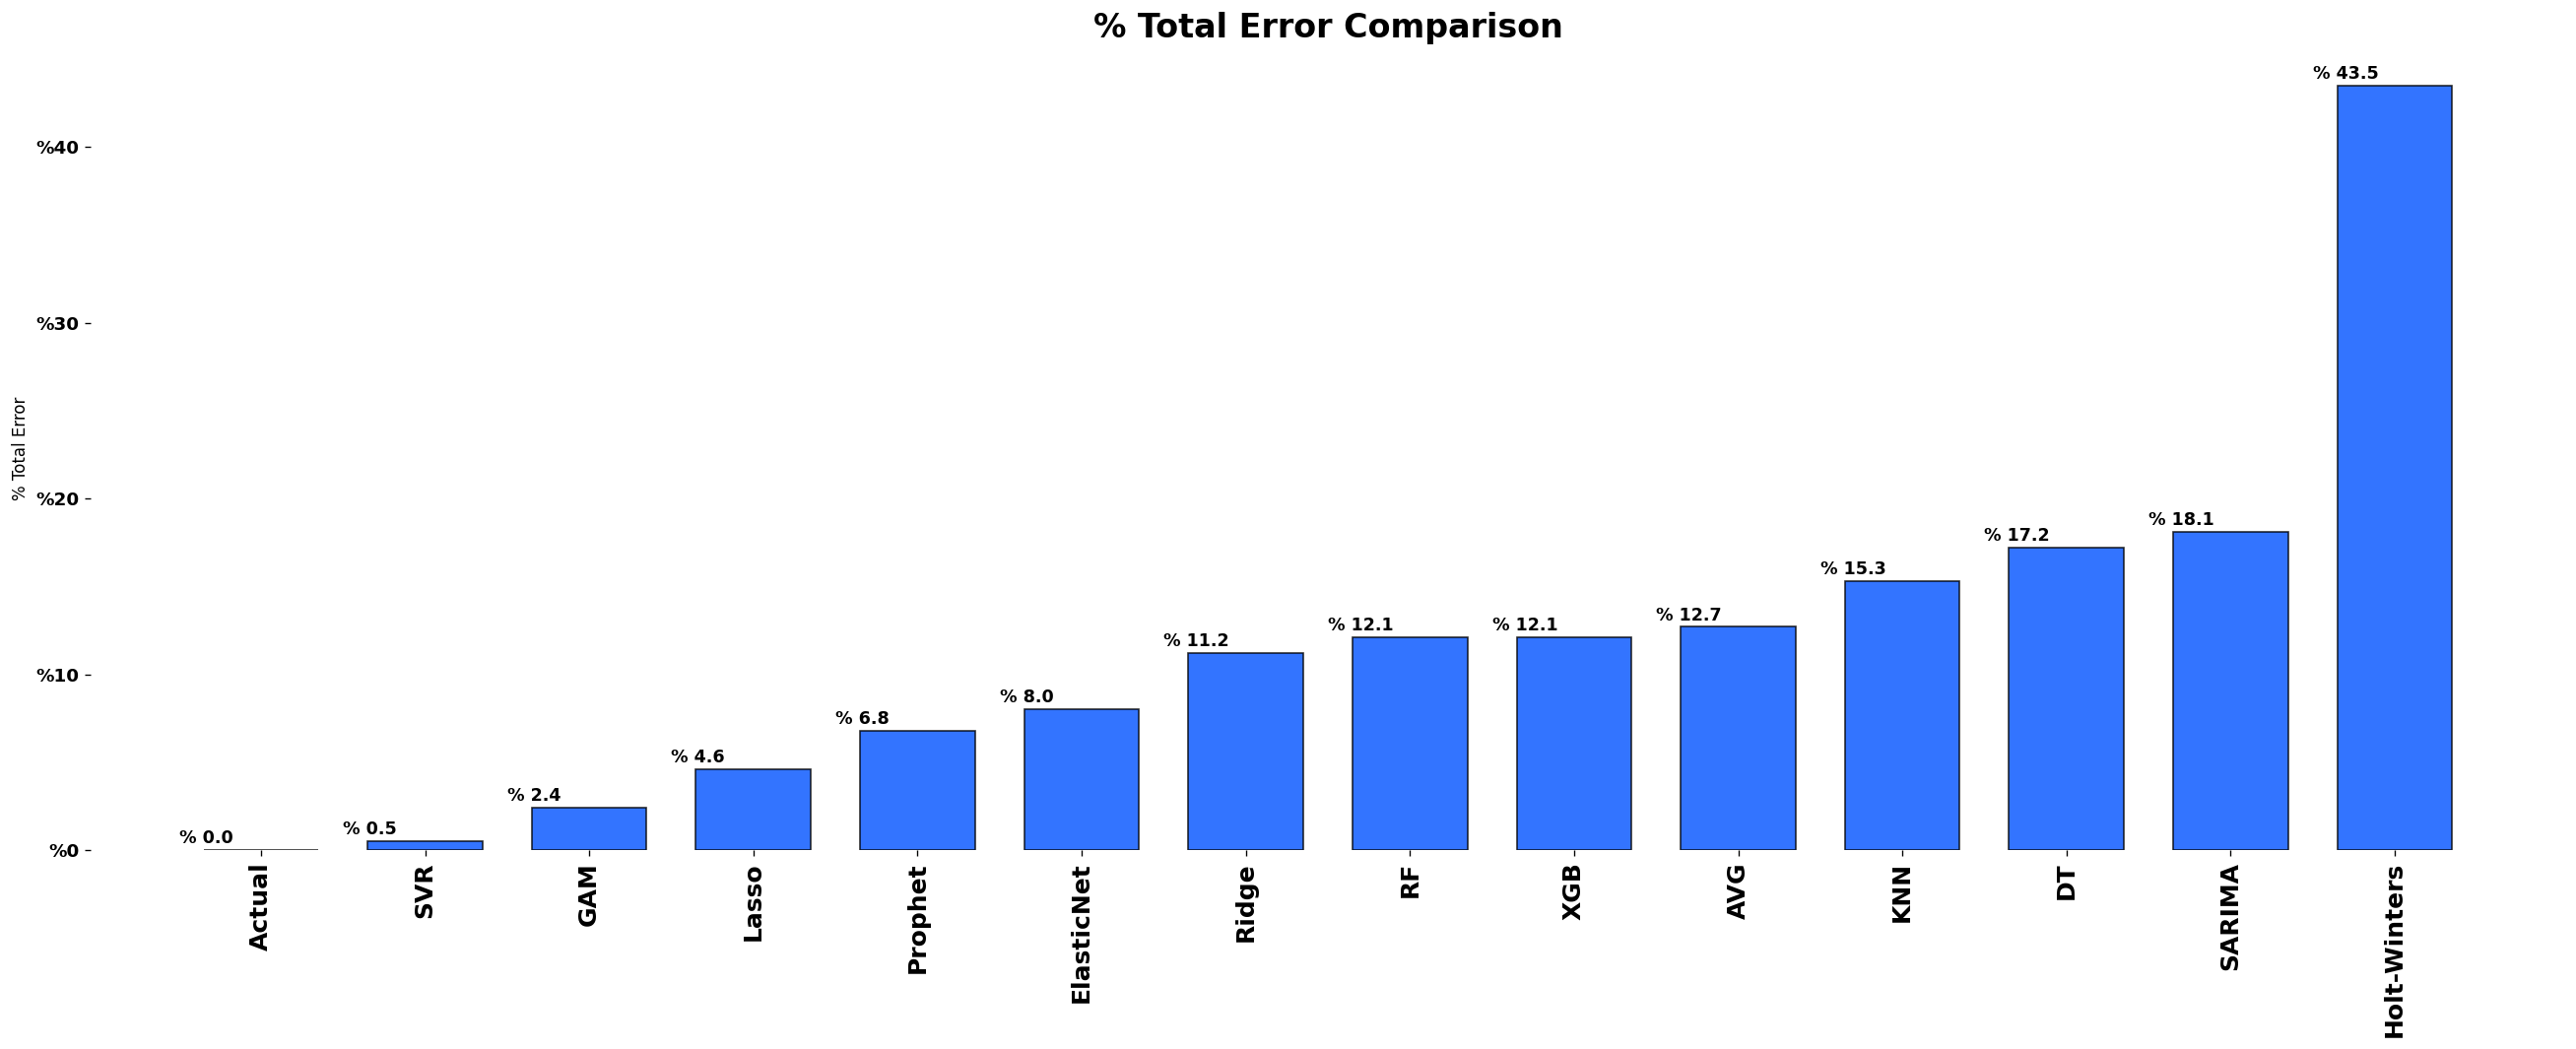

In [78]:

plt.figure()

x = np.arange(len(evaluation_table.index))
plt.bar(x+0.5,evaluation_table['Total Error %'].values, width= 0.7, align='center',color='#0052FF', alpha=0.8 ,edgecolor = 'black')

#X axis
plt.xticks([i + 0.5 for i in range(len(x))], evaluation_table.index, fontsize=15,fontweight='bold',rotation='vertical')

# Y axis
plt.yticks(fontsize=11, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('%{x:,.0f}'))

# Giving the tilte for the plot
plt.title("% Total Error Comparison",fontsize=20,fontweight='bold')

for y, xi in zip(evaluation_table['Total Error %'].values, x):
    plt.text(x = xi, y = y+0.4, s = '% {:.1f}'.format(y),
             color='black', size=10.5,fontweight='bold')
# Name for the x and y axis
plt.ylabel('% Total Error')

# Remove frame
plt.box(False)


All the tree-based models perform have a bad performance, the most accurate model (in terms of total error) is SVR and the worst model is Holt-Winters.

Gam, Lasso Prophet and ElasticNet have good performance as well.
Even though we only have data of quantities and dates, we succeeded to generate a pretty good forecast.

###Future Research

In order to make a more accurate and robust forecast, we can add more attributes to the dataset for making better feature engineering.

We also can try to use Deep Learning models for sequential data like RNNs (LSTM, GRU, etc.) or even more complex models like Amazon DeepAR, Google TFT, N-BEATS, Wavenet, etc.
